# Microsoft Stock Signal Prediction 

Using historical stock data to predict a "buy or sell" signal for a trading day. This notebook includes the following sections: 
- ##### Step 1: Feature Engineering 
- ##### Step 2: Data Preparation 
- ##### Step 3: Building LSTM Model to predict stock signals
- ##### Step 4: Performing Hyperparameter Tuning 

Modelling and evaluation was performed without Social Media Sentiments from Twitter, this notebook will be utilized to discuss the differences of results when social media sentiment is not included in model training

In [1]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 3.5MB/s 


In [25]:
# Loading required libraries
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras 
from keras.models import Sequential
from keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
import matplotlib.pyplot  as plt
import kerastuner as kt

pd.set_option("display.max_colwidth" , 100, "display.max_columns", 15)
np.random.seed(54)
tf.random.set_seed(54)


In [11]:
# Loading Raw Microsoft Stock data containing daily metrics
msft_df = pd.read_csv("D:\Stock Predicton\Datasets\TATAMOTORS_with_indicators_.csv")

# Loading Twitter Sentiment data containing daily twitter sentiment scores based on daily aggregate tweet analysis
# twitter_df = pd.read_csv("https://raw.githubusercontent.com/DDave94/Stock-Prediction-DL/main/datasets/msft-tweet-sentiments-lstm.csv")

### Feature Engineering
- Generating other prediction metrics such as:
    -  **Moving Average** : A moving average indicates the trend of the closing price movement and reduces the amount of "noise" on the price chart. We calculate different types of moving averages below. 
    - **Momentum** : The rate of acceleration at which the stock price is changing based on historical closing prices

- Adding Twitter sentiment feature column, the social media sentiment scores for each day of trading. However this feature will NOT be used for model training and evaluation. 
    - This data was only merged to create the same frame of reference for instaces as the other model which included twitter sentiments in analysis. This allows us to compare and contrast the existence of social media sentiment more effectively

- Generating target column "signal" using special moving averages 

In [14]:
#Creating target class - Signal
# The signal on a given trading day represents either 1-Buy or 0-Sell 
# The signal is calculated by comparing the future SMA and intermediate LMA
labelled_data = msft_df
# Creating signal_1
labelled_data['signal_1'] = np.where((labelled_data['ema5'] > labelled_data['ema15']) & (labelled_data['rsi'] < 30), 1.0, 0.0)

# Creating signal_-1
labelled_data['signal_-1'] = np.where((labelled_data['ema5'] < labelled_data['ema15']) & (labelled_data['rsi'] > 70), 1.0, 0.0)

# Creating signal_0
labelled_data['signal_0'] = np.where((labelled_data['rsi'] > 30) & (labelled_data['rsi'] < 70), 1.0, 0.0)

#Dropping the SMA and LMA columns to avoid data leakage
# labelled_data  = labelled_data.drop(columns = ['SMA', 'LMA'])
print(labelled_data.head())

                        date    open    high     low   close  volume  \
0  2015-02-02 14:30:00+05:30  591.30  591.85  590.05  590.05   46808   
1  2015-02-02 14:35:00+05:30  589.80  590.50  588.60  590.50   77183   
2  2015-02-02 14:40:00+05:30  590.25  591.55  589.45  589.45   62950   
3  2015-02-02 14:45:00+05:30  589.30  589.95  588.40  588.90   78077   
4  2015-02-02 14:50:00+05:30  588.90  591.70  588.40  591.00   66550   

         ema5  ...  middleband   lowerband      macd        rsi  signal_1  \
0  591.680691  ...      591.93  589.563061  1.900934  52.094286       0.0   
1  591.287127  ...      591.37  589.252832  1.687819  53.485096       0.0   
2  590.674751  ...      590.93  588.362044  1.417853  49.848507       0.0   
3  590.083168  ...      590.09  588.272970  1.146309  48.007202       0.0   
4  590.388778  ...      589.98  588.493259  1.088018  54.862858       0.0   

   signal_-1  signal_0  
0        0.0       1.0  
1        0.0       1.0  
2        0.0       1.0  
3   

### Data Preparation 
- Scaling all features (except 'Date' and 'Signal') in labelled dataset before model training
- Creating time series datasets for model input and evaluation

In [16]:
# Creating the MinMaxScaler Object
scaler = MinMaxScaler()

temp = labelled_data.drop(['date', 'signal_1', 'signal_-1', 'signal_0'], axis=1)
cols = temp.columns

#Creating scaled data
temp = scaler.fit_transform(temp)

#Generating input_df which will be used for model training and predictions
input_df = pd.concat([labelled_data['date'],pd.DataFrame(temp, columns = cols),
                      labelled_data['signal_1'], labelled_data['signal_-1'], labelled_data['signal_0']], 
                      axis=1, ignore_index=False)

input_df = input_df.dropna(axis=0)
print(input_df.head())
print(input_df.tail())

                        date      open      high       low     close  \
0  2015-02-02 14:30:00+05:30  0.962781  0.963183  0.964112  0.960062   
1  2015-02-02 14:35:00+05:30  0.960044  0.960716  0.961457  0.960883   
2  2015-02-02 14:40:00+05:30  0.960865  0.962635  0.963014  0.958968   
3  2015-02-02 14:45:00+05:30  0.959132  0.959711  0.961091  0.957965   
4  2015-02-02 14:50:00+05:30  0.958402  0.962909  0.961091  0.961794   

     volume      ema5  ...  middleband  lowerband      macd       rsi  \
0  0.000894  0.967682  ...    0.967385   0.964853  0.503202  0.523947   
1  0.001475  0.966959  ...    0.966357   0.964285  0.496727  0.538996   
2  0.001203  0.965834  ...    0.965550   0.962652  0.488525  0.499647   
3  0.001492  0.964748  ...    0.964009   0.962489  0.480275  0.479723   
4  0.001271  0.965309  ...    0.963807   0.962892  0.478504  0.553904   

   signal_1  signal_-1  signal_0  
0       0.0        0.0       1.0  
1       0.0        0.0       1.0  
2       0.0        0.0 

In [17]:
# Splitting entire data to create Training and Testing Data
# We will need to split the training and testing data into equivalent 
# time steps to train the Model

# Creating Training and Testing indices
train_data_size = int((0.7)*(input_df.shape[0]))
test_data_size = int(input_df.shape[0] - train_data_size)

# Allocating data instances to training and testing sets, excluding the date
train_data = input_df.iloc[0:train_data_size,1:]
test_data = input_df.iloc[train_data_size:input_df.shape[0],1:]


full_training_data = train_data # Used during model prediction
full_test_data = test_data  # Used during model prediction

# Creating numpy arrays from dataframes for future processing
train_data = np.array(train_data)
test_data = np.array(test_data)

print(train_data.shape)
print(test_data.shape)

(91242, 17)
(39105, 17)


#### Time Series Data Creation

In [20]:
# Creating X_train and y_train
# As an example, this function looks back at five days of trading:
# X - Consists of all features excluding signal from last 5 days 
# y - Consists of signal from one day ahead

X_train = []
y_train = []

time_step = 5
label_col = (train_data.shape[1]-3)

for i in range(time_step, train_data.shape[0]):
    X_train.append(train_data[i-time_step:i,:label_col])
    y_train.append(train_data[i,-3:])
    
X_train, y_train = np.array(X_train), np.array(y_train)

print('\nShapes of X_train and Y_train:\n')
print(X_train.shape)
print(y_train.shape)

print('\nFirst Element in X_train and Y_train:\n')
print(X_train[0])
print('-----------------')
print(y_train[0])


Shapes of X_train and Y_train:

(91237, 5, 14)
(91237, 3)

First Element in X_train and Y_train:

[[9.62780515e-01 9.63182898e-01 9.64112423e-01 9.60062004e-01
  8.94221922e-04 9.67681727e-01 9.69018434e-01 9.68852725e-01
  9.68046525e-01 9.61599498e-01 9.67384525e-01 9.64853234e-01
  5.03201925e-01 5.23947163e-01]
 [9.60043788e-01 9.60716243e-01 9.61457475e-01 9.60882648e-01
  1.47450715e-03 9.66958886e-01 9.68628941e-01 9.68747177e-01
  9.68093781e-01 9.60127513e-01 9.66357266e-01 9.64284602e-01
  4.96727075e-01 5.38996248e-01]
 [9.60864806e-01 9.62634752e-01 9.63013824e-01 9.58967813e-01
  1.20259934e-03 9.65834162e-01 9.67958891e-01 9.68412908e-01
  9.67952099e-01 9.60147124e-01 9.65550134e-01 9.62651838e-01
  4.88525004e-01 4.99647002e-01]
 [9.59131545e-01 9.59711310e-01 9.61091275e-01 9.57964804e-01
  1.49158616e-03 9.64747626e-01 9.67226615e-01 9.67993706e-01
  9.67727301e-01 9.57255173e-01 9.64009245e-01 9.62488570e-01
  4.80274979e-01 4.79723389e-01]
 [9.58401752e-01 9.629088

In [22]:
# Creating X_test and y_test
# As an example, this function looks back at five days of trading:
# X - Consists of all features excluding signal from last 5 days 
# y - Consists of signal from one day ahead

X_test = []
y_test = []

# Gathering the last five days of training data as this 
# will be used to predict the first few labels in y_test
last_5_days = full_training_data.tail()
# test_data_df = last_5_days.append([full_test_data], ignore_index=True)
# Using pd.concat instead of append
test_data_df = pd.concat([last_5_days, full_test_data], ignore_index=True)

for i in range(time_step, test_data_df.shape[0]):
    X_test.append(test_data_df.iloc[i-time_step:i,:label_col])
    y_test.append(test_data_df.iloc[i, -3:])

X_test, y_test = np.array(X_test), np.array(y_test)
print('\nShapes of X_test and Y_test:\n')
print(X_test.shape)
print(y_test.shape)

print('\nFirst Element in X_test and Y_test:\n')
print(X_test[0])
print(y_test[0])


Shapes of X_test and Y_test:

(39105, 5, 14)
(39105, 3)

First Element in X_test and Y_test:

[[0.2401934  0.23890005 0.24086789 0.23999271 0.0033157  0.23928588
  0.23907111 0.23932957 0.23960639 0.2365876  0.23940639 0.24110651
  0.43576184 0.46281411]
 [0.24010217 0.23890005 0.24059324 0.24026625 0.00315591 0.23944335
  0.23916537 0.23937392 0.23961927 0.23679506 0.23951645 0.24111728
  0.43709355 0.4878016 ]
 [0.24046707 0.23890005 0.24086789 0.23999271 0.00235453 0.2394565
  0.2391923  0.23937816 0.23960457 0.23682567 0.23958983 0.24123304
  0.43786857 0.46439176]
 [0.24010217 0.24017906 0.24105099 0.2410869  0.01342982 0.2398326
  0.23941511 0.23952011 0.23969667 0.23725816 0.23995671 0.24153013
  0.44001633 0.55713574]
 [0.24119686 0.24017906 0.24187494 0.24145163 0.00760564 0.24020578
  0.23966434 0.2396904  0.23981512 0.23788997 0.24019518 0.24136961
  0.44224568 0.58356317]]
[0. 0. 1.]


### Intial Modeling and Evaluation
- Building, Compiling, and Training deep learning model
- Evaluating model by comparing predicted signals against actual signals in testing data defined by X_test and y_test

In [38]:
# Model definition
def build_model():

    model = Sequential()

    model.add(LSTM(units = 30, activation = 'relu',input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
   
    model.add(Dense(units = 10, activation = 'relu'))
           
    model.add(Dense(units = 3, activation = 'softmax'))
   
    print(model.summary())

    return model

# Model Compile
def compile_model(model):

    met = [keras.metrics.BinaryAccuracy(name='accuracy'),keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall'), keras.metrics.AUC(name='auc')]
    
    model.compile(optimizer='adam', loss = CategoricalCrossentropy(), metrics = met)

    return model

# Model Training
def train_model(model, X_train, y_train):
    
    batch_size = 32
    epochs = 45 

    #Capturing the unique counts of 0 and 1 signal classes
    (unique,counts) = np.unique(y_train, return_counts=True)
    frequencies = np.asarray((unique, counts)).T
    
    neg = frequencies[0][1]
    pos= frequencies[1][1]
    total = neg+pos

    #Calculating weights for teh two binary classes
    weight_for_0 = (1 / neg)*(total)/2.0 
    weight_for_1 = (1 / pos)*(total)/2.0
    
    #Defining parameters for the class weights
    cw = {0: weight_for_0, 1: weight_for_1}
       
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose = 1)

    return model, history

# Model Evaluation and Results Evaluation
def eval_model(m, test_X, test_y):

    y_pred = m.predict(test_X)
    y_pred = y_pred.argmax(axis=1)  # Get the index of the max value as the predicted class
    test_y_labels = test_y.argmax(axis=1)  # Convert test_y from one-hot encoding to single integer labels

    print('CONFUSION MATRIX: \n')
    cmtx = pd.DataFrame(
        confusion_matrix(test_y_labels, y_pred), 
        index=['true:{}'.format(x) for x in np.unique(test_y_labels)], 
        columns=['pred:{}'.format(x) for x in np.unique(y_pred)]
    )
    print(cmtx)


    print('\nCLASSFICATION REPORT: \n')
    print(classification_report(test_y, y_pred.round()))

    # Visualising the results
    print('\nMODEL PREDICTIONS VS ACTUAL: \n')
    plt.figure(figsize=(14,5))
    plt.plot(test_y, color = 'red', label = 'Actual Buy/Sell Signal ')
    plt.plot(y_pred, color = 'blue', label = 'Predicted Buy/Sell Signal')
    plt.title('MSFT LSTM Stock Buy/Sell Prediction - Without Twitter Sentiment')
    plt.xlabel('Time')
    plt.ylabel('MSFT Stock Signal')
    plt.legend(loc='best')
    plt.show()
   
    return None


In [13]:
# Class Imbalance
# (unique,counts) = np.unique(y_train, return_counts=True)
# frequencies = np.asarray((unique, counts)).T
# print('Training Instances with Class 0:  ' + str(frequencies[0][1]))
# print('Training Instances with Class 1:  ' + str(frequencies[1][1]))
# total = int(frequencies[0][1]) + int(frequencies[1][1])
# print('Total Training instances:  '+str(total))

Training Instances with Class 0:  190.0
Training Instances with Class 1:  446.0
Total Training instances:  636


In [33]:
# Executing model building, compiling and training 
# During model training, we print the 
model = build_model()
model = compile_model(model)
model, history = train_model(model, X_train, y_train)

c:\Users\g6kan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30)             │         5,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,743 (22.43 KB)

 Trainable params: 5,743 (22.43 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/45
2852/2852 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9253 - auc: 0.9341 - loss: 5587052.0000 - precision: 0.8298 - recall: 0.9349
Epoch 2/45
2852/2852 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9139 - auc: 0.9173 - loss: 640013056.0000 - precision: 0.8068 - recall: 0.9252
Epoch 3/45
2852/2852 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9132 - auc: 0.9164 - loss: 6601708544.0000 - precision: 0.8058 - recall: 0.9239
Epoch 4/45
2852/2852 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9146 - auc: 0.9181 - loss: 27371431936.0000 - precision: 0.8079 - recall: 0.9264
Epoch 5/45
2852/2852 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9135 - auc: 0.9169 - loss: 84972552192.0000 - precision: 0.8064 - recall: 0.9244
Epoch 6/45
2852/2852 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9143 - auc: 0.9179 - loss: 216787943424.0000 - precision: 0.8076 - recall: 0.9257
Epoch 7/45
2852/2852 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9134 - auc: 0.9168 - loss: 525104152576


MODEL TRAINING RESULTS



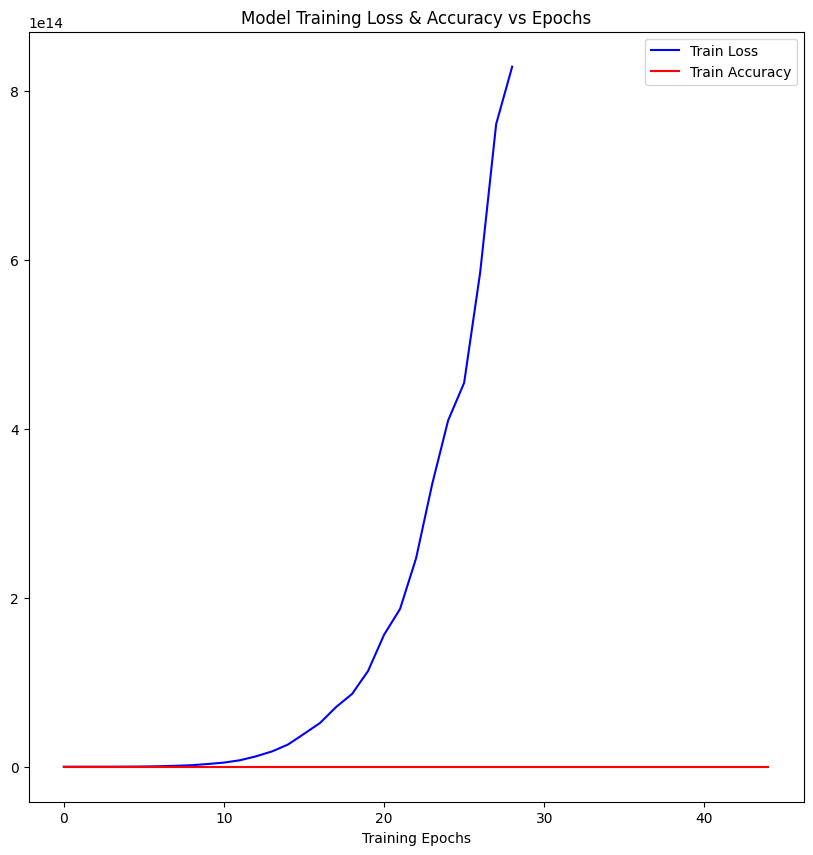

In [34]:
# Plotting Training loss vs Epochs 
def plot_curves(history): 
    
    print('\nMODEL TRAINING RESULTS\n')
    plt.figure(figsize=(10,10))
    plt.plot(history.history['loss'], color = 'blue')
    plt.plot(history.history['accuracy'], color = 'red')
    plt.title('Model Training Loss & Accuracy vs Epochs')
    plt.xlabel('Training Epochs')
    plt.legend(['Train Loss', 'Train Accuracy'], loc='best')
    plt.show()
        
plot_curves(history)

In [39]:
# Testing Initial Model 
# Printing Confusion Matrix, Classification Report, and Visualizing Predicted Signal
tf.keras.utils.plot_model(model, to_file='MSFT-LSTM-without-Sentiment-Normal.png', show_shapes=True)
eval_model(model, X_test, y_test)

You must install pydot (`pip install pydot`) for `plot_model` to work.
1223/1223 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
CONFUSION MATRIX: 



ValueError: Shape of passed values is (2, 2), indices imply (2, 1)

### Hyperparameter Tuning
- Creating Hyper parameter model and using the RandomSearch tuner class for performing tuning. 
- Tuner obtains the best values for hyperparameters such as input llayer units, input lyaer dropout, hidden layer cells, and learning rate 
- Using the best values, we create another model to find the optimal number 
of epochs which minimizes training loss
- Lastly, create a final model which uses the optimal values for hyperparameters and epochs to build the best model and performing evaluation

In [30]:
def model_builder(hp):

    #Defining Model 
    hyper_model = Sequential()

    hyper_model.add(LSTM(units = hp.Int('input_layer', 10, 90, step=10), activation = 'relu', input_shape = (X_train.shape[1], X_train.shape[2])))
    hyper_model.add(Dropout(hp.Choice('Drop1', values = [0.1,0.2,0.3])))
        
    hyper_model.add(Dense(units = hp.Choice('hidden_1', values = [10,20,30,60,80,100]), activation = 'relu'))
        
    hyper_model.add(Dense(units = 1, activation = 'sigmoid'))
        
    hyper_model.compile(optimizer = Adam(learning_rate=hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])),
                        loss = BinaryCrossentropy(), metrics=['accuracy'])
        
    return hyper_model


In [18]:
# Defining Random Search Tuner and performing hyperparameter tuning
obj = kt.Objective("loss", direction="min")
tuner = kt.tuners.randomsearch.RandomSearch(model_builder, objective=obj, max_trials=25, seed=42, overwrite = True)

tuner.search(X_train, y_train, epochs=80)

# Get the optimal hyperparameter values for model layers
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. 

The optimal number of units in the input layer is {best_hps.get('input_layer')}. 
The optimal amount of dropout in the input layer is {best_hps.get('Drop1')}. 
The optimal number of units in the first hidden layer is {best_hps.get('hidden_1')}. 
The optimal learning rate is {best_hps.get('learning_rate')}.
""")


Trial 25 Complete [00h 00m 17s]
loss: 0.5635668635368347

Best loss So Far: 0.3190479278564453
Total elapsed time: 00h 06m 57s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. 

The optimal number of units in the input layer is 80. 
The optimal amount of dropout in the input layer is 0.1. 
The optimal number of units in the first hidden layer is 80. 
The optimal learning rate is 0.01.



#### Evaluating Tuned Model 
- In Step One, we create the model using the best hyperparameter values identified during tuning. Then we find the epoch in which we obtain our objective. 

- In Step Two, we recreate the model using the optimal hyperparameter values and the ideal number of training epochs. Then we train and evaluate this model to compare results against the first non-tuned model with random parameters

In [19]:
#Step One
model_Two = tuner.hypermodel.build(best_hps)
history = model_Two.fit(X_train, y_train, epochs=80)

acc_per_epoch = history.history['accuracy']
best_epoch = acc_per_epoch.index(max(acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/80
20/20 [==============================] - 1s 9ms/step - loss: 0.6301 - accuracy: 0.6555
Epoch 2/80
20/20 [==============================] - 0s 9ms/step - loss: 0.6186 - accuracy: 0.6966
Epoch 3/80
20/20 [==============================] - 0s 8ms/step - loss: 0.5951 - accuracy: 0.7132
Epoch 4/80
20/20 [==============================] - 0s 9ms/step - loss: 0.5946 - accuracy: 0.7111
Epoch 5/80
20/20 [==============================] - 0s 9ms/step - loss: 0.6044 - accuracy: 0.6838
Epoch 6/80
20/20 [==============================] - 0s 9ms/step - loss: 0.6008 - accuracy: 0.6796
Epoch 7/80
20/20 [==============================] - 0s 10ms/step - loss: 0.5423 - accuracy: 0.7313
Epoch 8/80
20/20 [==============================] - 0s 9ms/step - loss: 0.5602 - accuracy: 0.7128
Epoch 9/80
20/20 [==============================] - 0s 10ms/step - loss: 0.6601 - accuracy: 0.5996
Epoch 10/80
20/20 [==============================] - 0s 9ms/step - loss: 0.5917 - accuracy: 0.6975
Epoch 11/80
20/20

In [20]:
#Step Two
model_three = tuner.hypermodel.build(best_hps)

# Retrain the final model using the best number of epochs
tuned_history = model_three.fit(X_train, y_train, epochs=best_epoch)

Epoch 1/68
20/20 [==============================] - 1s 9ms/step - loss: 0.6301 - accuracy: 0.6880
Epoch 2/68
20/20 [==============================] - 0s 10ms/step - loss: 0.6194 - accuracy: 0.6966
Epoch 3/68
20/20 [==============================] - 0s 9ms/step - loss: 0.5971 - accuracy: 0.7132
Epoch 4/68
20/20 [==============================] - 0s 10ms/step - loss: 0.5956 - accuracy: 0.7111
Epoch 5/68
20/20 [==============================] - 0s 9ms/step - loss: 0.6144 - accuracy: 0.6838
Epoch 6/68
20/20 [==============================] - 0s 9ms/step - loss: 0.6020 - accuracy: 0.6815
Epoch 7/68
20/20 [==============================] - 0s 8ms/step - loss: 0.5496 - accuracy: 0.7325
Epoch 8/68
20/20 [==============================] - 0s 9ms/step - loss: 0.5859 - accuracy: 0.6971
Epoch 9/68
20/20 [==============================] - 0s 8ms/step - loss: 0.5393 - accuracy: 0.7394
Epoch 10/68
20/20 [==============================] - 0s 9ms/step - loss: 0.6583 - accuracy: 0.5956
Epoch 11/68
20/20


MODEL TRAINING RESULTS



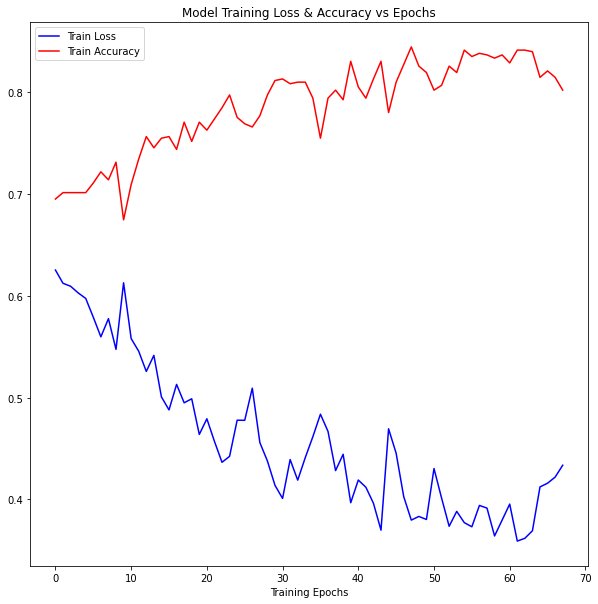

In [21]:
plot_curves(tuned_history)

9/9 [==============================] - 0s 2ms/step - loss: 0.3833 - accuracy: 0.8545
[test loss, test accuracy]: [0.38334619998931885, 0.8545454740524292]
CONFUSION MATRIX: 

            pred:0.0  pred:1.0
  true:0.0        36        37
  true:1.0         3       199

CLASSFICATION REPORT: 

              precision    recall  f1-score   support

         0.0       0.92      0.49      0.64        73
         1.0       0.84      0.99      0.91       202

    accuracy                           0.85       275
   macro avg       0.88      0.74      0.78       275
weighted avg       0.86      0.85      0.84       275


MODEL PREDICTIONS VS ACTUAL: 



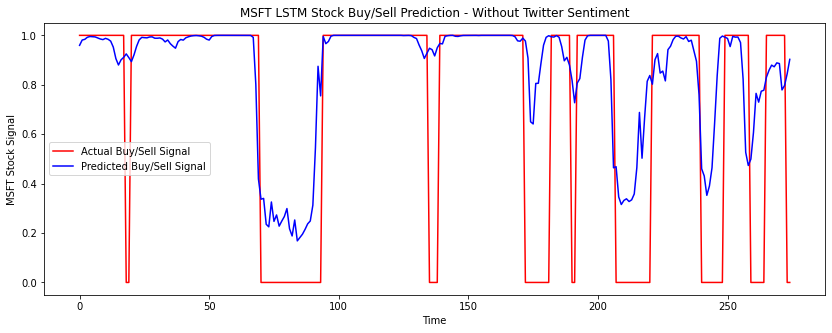

In [22]:
# Tuned Model Evaluation
# Printing Confusion Matrix, Classification Report, and Visualizing the Predicted Signal
eval_result = model_three.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

tf.keras.utils.plot_model(model_three, to_file='MSFT-LSTM-without-Sentiment-Tuned.png', show_shapes=True)

eval_model(model_three, X_test, y_test)